**MAESTRÍA EN INTELIGENCIA ARTIFICIAL APLICADA**

**Curso: Proyecto integrador**

Tecnológico de Monterrey

Prof Grettel Barceló Alonso

**Semana 6**
Avance 4. Modelos alternativos
---

*  Salvador Martínez Morales A01273366
*  Fernando Acevedo Ortegate A01794022
*  José Francisco Miranda García A00837306


Como parte del avance en esta actividad, retomaremos lo trabajado la semana pasada, realizando un análisis más exhaustivo de los ajustes implementados.

### Importamos librerías necesarias

In [120]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

import mysql.connector
import matplotlib.pyplot as plt

In [121]:
# !pip install mysql-connector-python==8.0.32

In [122]:
# Obtiene IP del NoteBook

# !curl ipecho.net/plain

### Conexión a base de datos y extracción de información

Para este primer ejercicio de comprensión de datos, extraeremos solo 1000 registros, de los cuales seleccionaremos las columnas que mejor describan la operación de cada una de las sucursales que analizaremos.

In [123]:
# Configura conexión con base de datos de MYSql alojada en GCP

db_connection = mysql.connector.connect(
  host="localhost",
  user="root",
  password="Test123@",
  database="DB_ZAB"
)

cursor = db_connection.cursor()

In [124]:
# Valida estatus de conexión

cursor.execute("SELECT VERSION()")
testConnection = cursor.fetchone()
print(f"Database version: {testConnection[0]}")

Database version: 9.0.1


Para la consulta, utilizaremos una parte de los datos que deseamos analizar. En este caso, nos interesan las siguientes columnas:
* vch_identifier: corresponde al identificador de la sucursal.
* txt_prediction: contiene objetos tipo JSON con diversos valores, como tiempo de servicio, tiempo de espera y número de cajas abiertas por hora.
* int_checkouts: número de checkouts propuestos.
* FLT_TimeAttentionReal: tiempo real de atención.

Todos estos datos provienen de nuestra tabla principal TBL_Snapshots.

In [125]:
# Query de consulta limitada a 100,000 registros, se puede extraer más información, el tamaño actual de la tabla es de 300,000 registros
query = "SELECT vch_identifier, txt_prediction, INT_CheckoutsReal, FLT_TimeAttentionReal FROM TBL_Snapshots LIMIT 100000;"

In [126]:
# Cargamos los datos en un DataFrame para realizar el análisis a continuación
data = pd.read_sql(query, con=db_connection)
db_connection.close()

# Imprimimos los primeros 5 registros
data.head()

C:\Users\SALVA\AppData\Local\Temp\ipykernel_23860\1403606791.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(query, con=db_connection)


,vch_identifier,txt_prediction,INT_CheckoutsReal,FLT_TimeAttentionReal
0,ZA2,"{""tables"":{""checkouts"":["""","""","""","""","""","""",""1"",...",10.0,106.3470
1,CNA,"{""tables"":{""checkouts"":["""","""","""","""","""","""",""1"",...",4.0,82.2148
2,ZPA,"{""tables"":{""checkouts"":["""","""","""","""","""","""",""1"",...",5.0,78.0680
3,CNA,"{""tables"":{""checkouts"":["""","""","""","""","""","""",""1"",...",4.0,83.7523
4,ZRY,"{""tables"":{""checkouts"":["""","""","""","""","""","""",""1"",...",9.0,92.9797


## Parte 1, análisis de datos

### Procesamiento de columna txt_prediction de objetos tipo JSON

Nuestro conjunto de datos contiene una serie de objetos en formato JSON, de los cuales debemos extraer la información para su posterior análisis. A continuación, se muestra un ejemplo de cómo se presenta el objeto JSON, del cual nos interesa extraer el objeto Tables con los valores: checkouts, services, waitings y arrives.

{
  "tables": {
    "checkouts": [
      "",
      "",
      "",
      "",
      "",
      "",
      "1",
      "5",
      "7",
      "8",
      "8",
      "8",
      "9",
      "9",
      "9",
      "10",
      "9",
      "9",
      "9",
      "8",
      "6",
      "1"
    ],
    "services": [
      "",
      "",
      "",
      "",
      "",
      "",
      "0.0",
      "1.7",
      "2.0",
      "2.0",
      "2.0",
      "1.9",
      "1.9",
      "2.0",
      "1.9",
      "2.1",
      "2.0",
      "1.8",
      "1.9",
      "2.1",
      "2.0",
      "3.3"
    ],
    "waitings": [
      "",
      "",
      "",
      "",
      "",
      "",
      "0.3",
      "6.6",
      "9.4",
      "7.8",
      "8.7",
      "8.7",
      "9",
      "9",
      "7.7",
      "7.4",
      "7.2",
      "9",
      "8.5",
      "9.4",
      "7.7",
      "1.8"
    ],
    "arrives": [
      "",
      "",
      "",
      "",
      "",
      "",
      "1",
      "49",
      "77",
      "83",
      "86",
      "86",
      "98",
      "98",
      "93",
      "102",
      "91",
      "98",
      "96",
      "88",
      "62",
      "5"
    ]
  },
  "graphs": {
    "checkouts": [
      [
        "1",
        "6",
        "7",
        "8",
        "8",
        "8",
        "10",
        "9",
        "9",
        "9",
        "10",
        "9",
        "9",
        "8",
        "7",
        "3"
      ],
      [
        "1",
        "5",
        "7",
        "8",
        "8",
        "8",
        "9",
        "9",
        "9",
        "10",
        "9",
        "9",
        "9",
        "8",
        "6",
        "1"
      ]
    ],
    "services": [
      [
        "0.0",
        "1.7",
        "2.0",
        "2.0",
        "2.0",
        "1.9",
        "1.9",
        "2.0",
        "1.9",
        "2.1",
        "2.0",
        "1.8",
        "1.9",
        "2.1",
        "2.0",
        "3.3"
      ]
    ],
    "waitings": [
      [
        "0.3",
        "6.6",
        "9.4",
        "7.8",
        "8.7",
        "8.7",
        "9",
        "9",
        "7.7",
        "7.4",
        "7.2",
        "9",
        "8.5",
        "9.4",
        "7.7",
        "1.8"
      ]
    ],
    "arrives": [
      [
        "1",
        "49",
        "77",
        "83",
        "86",
        "86",
        "98",
        "98",
        "93",
        "102",
        "91",
        "98",
        "96",
        "88",
        "62",
        "5"
      ]
    ],
    "costs": [
      [
        "2.40",
        "24079.51",
        "48794.00",
        "51257.66",
        "49936.88",
        "45209.72",
        "54947.95",
        "59885.56",
        "52444.49",
        "54312.74",
        "51119.75",
        "50535.40",
        "48241.63",
        "55121.12",
        "31156.93",
        "5911.08"
      ]
    ],
    "cozts": [
      [
        "2.40",
        "512.33",
        "588.77",
        "599.50",
        "533.37",
        "492.75",
        "520.83",
        "547.53",
        "513.53",
        "547.92",
        "495.71",
        "486.50",
        "452.97",
        "533.86",
        "477.50",
        "824.80"
      ]
    ],
    "labels": [
      "6",
      "7",
      "8",
      "9",
      "10",
      "11",
      "12",
      "13",
      "14",
      "15",
      "16",
      "17",
      "18",
      "19",
      "20",
      "21"
    ]
  }
}


Función de extracción y procesamiento de datos tipo JSON

In [127]:
import pandas as pd
import json

def extract_json_fields(json_str):
    try:
        # Paso 1, se extrae el json de la columna txt_prediction
        json_data = json.loads(json_str.replace('\'', '\"'))
        if isinstance(json_data, str):
            json_data = json.loads(json_data)
        tables = json_data.get('tables', {})
    except json.JSONDecodeError:
        # Paso 2, en caso de que algún objeto esté mal formado o no tenga datos se le asigna un valor por defecto en la decodificación del JSON
        tables = {}

    # Paso 3, en este paso se decidió sumar todos los valores de cada hora por objeto, para obtener un valor global que utilizaremos en el análisis
    # en caso de que no se cuente con valor alguno (NAN) se le agrega un 0
    checkouts = sum(float(item) for item in tables.get('checkouts', []) if isinstance(item, (int, float, str)) and item != '')
    waitings = sum(float(item) for item in tables.get('waitings', []) if isinstance(item, (int, float, str)) and item != '')
    services = sum(float(item) for item in tables.get('services', []) if isinstance(item, (int, float, str)) and item != '')
    arrives = sum(float(item) for item in tables.get('arrives', []) if isinstance(item, (int, float, str)) and item != '')

    return pd.Series([checkouts, waitings, services, arrives], index=['checkouts', 'waitings', 'services', 'arrives'])

# Aplicamos nuestra función
data[['checkouts', 'waitings', 'services', 'arrives']] = data['txt_prediction'].apply(lambda x: extract_json_fields(x) if isinstance(x, str) else pd.Series([0, 0, 0, 0], index=['checkouts', 'waitings', 'services', 'arrives']))


In [128]:
# Crear un nuevo DataFrame con las columnas seleccionadas
new_dataset = data[['vch_identifier','waitings', 'services', 'arrives', 'FLT_TimeAttentionReal','INT_CheckoutsReal']].copy()
new_dataset.rename(columns={'vch_identifier': 'sucursal', 'FLT_TimeAttentionReal': 'tiemporealatencion'}, inplace=True)

print(new_dataset.head())

  sucursal  waitings  services  arrives  tiemporealatencion  INT_CheckoutsReal
0      ZA2     118.2      30.6   1213.0            106.3470               10.0
1      CNA      83.1      21.0    587.0             82.2148                4.0
2      ZPA     207.6      20.4    766.0             78.0680                5.0
3      CNA      91.8      21.0    587.0             83.7523                4.0
4      ZRY     112.0      23.8   1064.0             92.9797                9.0


In [129]:
# new_dataset.to_csv('archivo_DF.csv', index=False)

### Proceso de análisis de información y estadisticas descriptivas

#### Análisis de estadísticas descriptivas

Estadísiticas descriptivas

En esta sección, podemos observar de manera general los valores de nuestros datos, tanto en sus estadísticas descriptivas como en los tipos de datos correspondientes.

In [130]:
print(new_dataset.describe())

           waitings      services       arrives  tiemporealatencion  \
count  19968.000000  20035.000000  20035.000000        19861.000000   
mean     109.635226     25.254714    926.012828           97.364423   
std      225.003476     49.617203    297.183782           20.709879   
min        0.000000  -4262.400000      0.000000           50.314600   
25%       90.000000     21.100000    715.000000           84.115300   
50%      104.400000     24.000000    899.000000           93.336200   
75%      117.800000     27.200000   1078.500000          106.566000   
max    11879.900000    746.500000   2818.000000          213.729000   

       INT_CheckoutsReal  
count       19861.000000  
mean            6.445093  
std             1.788649  
min             2.000000  
25%             5.000000  
50%             6.000000  
75%             8.000000  
max            16.000000  


Tipos de variables

In [131]:
new_dataset.dtypes

sucursal               object
waitings              float64
services              float64
arrives               float64
tiemporealatencion    float64
INT_CheckoutsReal     float64
dtype: object

#### Generación de histogramas

De los siguientes histogramas podemos visualizar lo siguiente:

**Checkouts**: Se puede visualizar una distribución bimodal, con un sesgo de datos a la izquierda en donde los valores más altos están entre los 55 y 70 minutos

**Waitings**: Para los tiempos de espera podemos visualizar que son menores, es decir que hay una tendencia marcada a que los tiempos de espera sean bajos en referencia a los datos mostrados en general.

**Services**: Para el caso de los tiempos de servicio estos tienden a ser bajos igual que los tiempos de atención.

**Arrives**: En este caso la distribución es más homogenea (normal) en donde podemos observar un ligero sesgo a la izquierda donde se puede visualizar algunas llegadas atipicas que podremos observar de mejor fomra en los boxplots

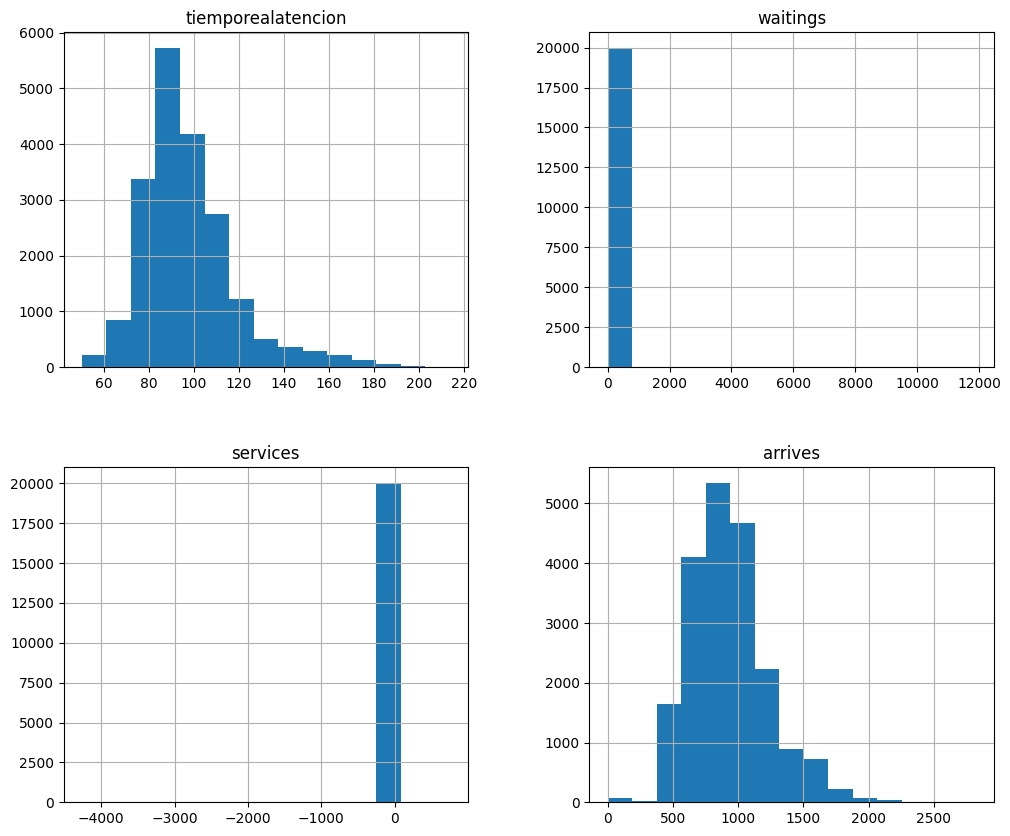

In [132]:
# Histogramas
new_dataset[['tiemporealatencion','waitings', 'services', 'arrives']].hist(bins=15, figsize=(12, 10))
plt.show()

#### Generación de cajas Boxplots

En los gráficos de caja, podemos observar que, en el caso de los tiempos de espera (waitings), los outliers son más pronunciados. Esto indica que, aunque generalmente los tiempos de espera son bajos, existen ciertas eventualidades que provocan prolongaciones significativas en algunas ocasiones.

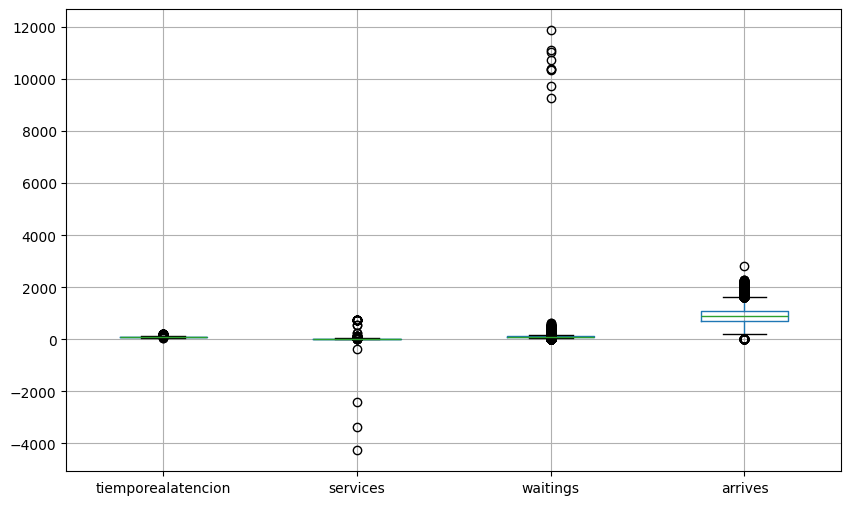

In [133]:
# Boxplots for each variable to show outliers
new_dataset.boxplot(column=['tiemporealatencion', 'services', 'waitings', 'arrives'], figsize=(10, 6))
plt.show()

#### Identificación de valores atípicos (Outliers)

In [134]:
outliers = new_dataset[['tiemporealatencion', 'services', 'waitings', 'arrives']].apply(lambda x: np.abs(x - x.mean()) > (3 * x.std()))
outliers.describe()

,tiemporealatencion,services,waitings,arrives
count,20035,20035,20035,20035
unique,2,2,2,2
top,False,False,False,False
freq,19624,20004,20026,19811


#### Conteo de valores (cardinalidad) para aquellos datos categoricos

Para este caso se contabilizó la frecuencia de registros por sucursal

In [135]:
# Conteo de registros por sucursal, contabilizado a los 1,000 registros de la consulta
data_suc = new_dataset['sucursal'].value_counts()
data_suc

sucursal
ZQ6    971
ZOZ    855
ZCL    808
ZCC    794
ZAM    759
      ... 
ZVM     44
ZL2     38
ZJR     32
ZM2     29
CNA     24
Name: count, Length: 69, dtype: int64

#### Análisis de destribución de los datos

In [136]:
from scipy.stats import skew
skewness = new_dataset[['tiemporealatencion', 'services', 'waitings', 'arrives']].apply(skew)
skewness

tiemporealatencion          NaN
services             -50.550937
waitings                    NaN
arrives                0.765711
dtype: float64

#### Análisis de tendencias (Checkouts)

Podemos observar una tendencia bastante variable en el número de checkouts. Aunque en algunos casos los valores son bajos, en otros, los números son significativamente mayores que los promedios.

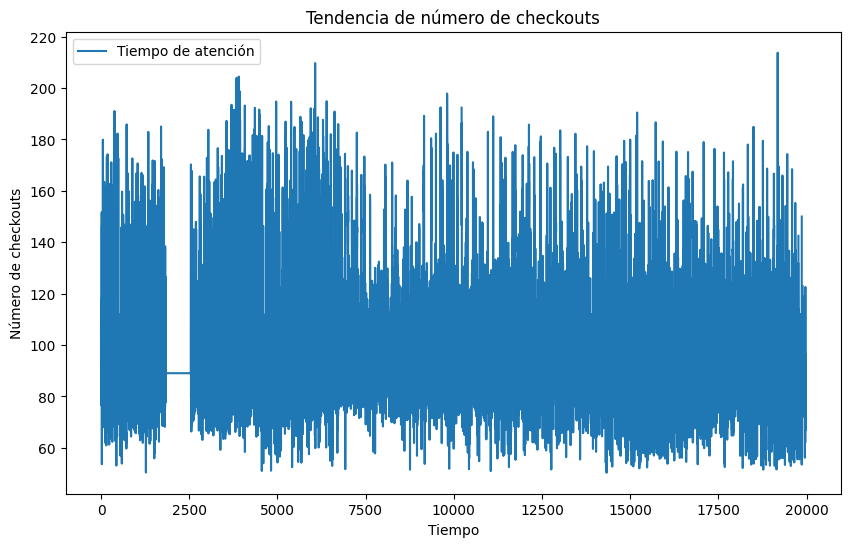

In [137]:
plt.figure(figsize=(10, 6))
plt.plot(new_dataset.index, new_dataset['tiemporealatencion'], label='Tiempo de atención')
plt.title('Tendencia de número de checkouts')
plt.xlabel('Tiempo')
plt.ylabel('Número de checkouts')
plt.legend()
plt.show()

#### Mapa de correlaciones

En este diagrama de correlación, podemos observar que las llegadas están fuertemente correlacionadas con los checkouts, seguidas por el tiempo de servicio. Esto es lógico, ya que un mayor número de llegadas requiere un mayor número de cajas abiertas. Al final, lo que buscamos es deducir cuántas cajas necesitamos tener abiertas para atender adecuadamente la demanda de una tienda en condiciones normales.

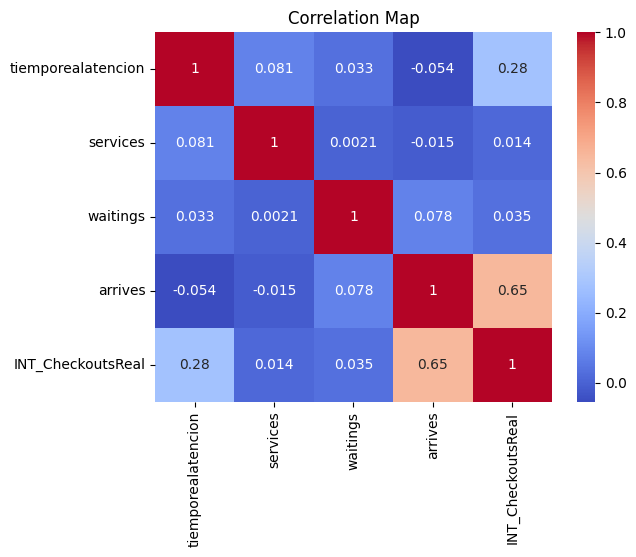

In [138]:
correlation = new_dataset[['tiemporealatencion', 'services', 'waitings', 'arrives', 'INT_CheckoutsReal']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Map')
plt.show()

#### Justificación y análisis de mapa de correlación

Identificar la correlación entre las ventas, el flujo de clientes y el número de cajas necesarias para satisfacer la demanda es crucial por varias razones:

*   **Optimización de Recursos**: Si existe una fuerte correlación, esto indica que a medida que aumenta el número de clientes, las ventas también crecen y se requiere más cajas. Conocer esta relación permite ajustar de manera eficiente el número de cajas y empleados necesarios durante las horas de mayor afluencia.
*   **Predicción más precisa**: Comprender cómo se relacionan estas variables ayuda a construir modelos predictivos más precisos. Un modelo que considere esta correlación puede captar patrones que otros modelos más simples podrían pasar por alto.
*   **Planificación Estratégica**: Analizar esta relación también brinda información sobre cómo los cambios en las ventas, promociones o incluso la disposición de la tienda pueden impactar tanto el flujo de clientes como las ventas, facilitando una mejor planificación a largo plazo.



## Parte 2, normalización de datos

En nuestro conjunto de datos, es necesario aplicar una transformación, ya que la mayoría de los datos están expresados en tiempo (minutos), a excepción de los checkouts, que presentan una distribución discreta.

In [139]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_scaled = scaler.fit_transform(new_dataset[['tiemporealatencion', 'services', 'waitings', 'arrives']])
data_scaled = pd.DataFrame(data_scaled, columns=['tiemporealatencion', 'services', 'waitings', 'arrives'])
data_scaled.head()


,tiemporealatencion,services,waitings,arrives
0,0.433745,0.107733,0.038066,0.965713
1,-0.731535,-0.085753,-0.117935,-1.140780
2,-0.931773,-0.097846,0.435403,-0.538444
3,-0.657293,-0.085753,-0.079268,-1.140780
4,-0.211727,-0.029319,0.010510,0.464328


Verificamos el número de datos nulos o vacíos en nuestras columnas

In [140]:
print(new_dataset.isnull().sum())

sucursal                0
waitings               67
services                0
arrives                 0
tiemporealatencion    174
INT_CheckoutsReal     174
dtype: int64


Para este caso imputaremos con la media las columnas:
*  waitings
*  tiemporealatencion

In [141]:
new_dataset['waitings'].fillna(new_dataset['waitings'].mean(), inplace=True)  # Imputar con la media
new_dataset['INT_CheckoutsReal'].fillna(new_dataset['INT_CheckoutsReal'].mean(), inplace=True)  # Imputar con la media
new_dataset['tiemporealatencion'].fillna(new_dataset['tiemporealatencion'].mean(), inplace=True)  # Imputar con la media

C:\Users\SALVA\AppData\Local\Temp\ipykernel_23860\1988497994.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  new_dataset['waitings'].fillna(new_dataset['waitings'].mean(), inplace=True)  # Imputar con la media
C:\Users\SALVA\AppData\Local\Temp\ipykernel_23860\1988497994.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we a

Verificamos nuevamente los valores nulos

In [142]:
print(new_dataset.isnull().sum())

sucursal              0
waitings              0
services              0
arrives               0
tiemporealatencion    0
INT_CheckoutsReal     0
dtype: int64


Para el caso de la variable categorica "Sucursal" la codificaremos para poder realizar el entrenamiento posteriormente

In [143]:
from sklearn.preprocessing import LabelEncoder

# Ejemplo de codificación con LabelEncoder
label_encoder = LabelEncoder()
new_dataset['sucursal'] = label_encoder.fit_transform(new_dataset['sucursal'])

In [144]:
new_dataset.head()

,sucursal,waitings,services,arrives,tiemporealatencion,INT_CheckoutsReal
0,4,118.2,30.6,1213.0,106.3470,10.0
1,1,83.1,21.0,587.0,82.2148,4.0
2,45,207.6,20.4,766.0,78.0680,5.0
3,1,91.8,21.0,587.0,83.7523,4.0
4,51,112.0,23.8,1064.0,92.9797,9.0


Aplicaremos un escalamiento a todas nuestras variables para que ajusten de mejor forma a nuestro algoritmo

In [145]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
new_dataset['arrives_scaled'] = scaler.fit_transform(new_dataset[['arrives']])
new_dataset['services_scaled'] = scaler.fit_transform(new_dataset[['services']])
new_dataset['waitings_scaled'] = scaler.fit_transform(new_dataset[['waitings']])
new_dataset['tiemporealatencion_scaled'] = scaler.fit_transform(new_dataset[['tiemporealatencion']])

In [146]:
new_dataset.head()

,sucursal,waitings,services,arrives,tiemporealatencion,INT_CheckoutsReal,arrives_scaled,services_scaled,waitings_scaled,tiemporealatencion_scaled
0,4,118.2,30.6,1213.0,106.3470,10.0,0.965713,0.107733,0.038130,0.435641
1,1,83.1,21.0,587.0,82.2148,4.0,-1.140780,-0.085753,-0.118133,-0.734733
2,45,207.6,20.4,766.0,78.0680,5.0,-0.538444,-0.097846,0.436133,-0.935846
3,1,91.8,21.0,587.0,83.7523,4.0,-1.140780,-0.085753,-0.079401,-0.660166
4,51,112.0,23.8,1064.0,92.9797,9.0,0.464328,-0.029319,0.010528,-0.212652


Por último eliminaremos algunos outliers que observamos en el diagrama de caja, para tener un set de datos más limpio

In [147]:
def remove_outliers_iqr(df, columns):
    for column in columns:
        
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

# Columnas de las cuales eliminaremos los outliers
columns_to_clean = ['tiemporealatencion', 'services', 'waitings', 'arrives']

final_df = remove_outliers_iqr(new_dataset, columns_to_clean)
print(final_df)

       sucursal  waitings  services  arrives  tiemporealatencion  \
0             4     118.2      30.6   1213.0          106.347000   
1             1      83.1      21.0    587.0           82.214800   
3             1      91.8      21.0    587.0           83.752300   
4            51     112.0      23.8   1064.0           92.979700   
5            51     120.0      24.6   1092.0          109.812000   
...         ...       ...       ...      ...                 ...   
20026        34      64.3      29.4   1189.0           97.364423   
20027        34      60.8      26.2   1052.0           97.364423   
20028        59      56.3      24.3    593.0           97.364423   
20029        21      51.2      29.4   1564.0           97.364423   
20030        21      52.0      28.3   1563.0           97.364423   

       INT_CheckoutsReal  arrives_scaled  services_scaled  waitings_scaled  \
0              10.000000        0.965713         0.107733         0.038130   
1               4.000000   

Por último observaremos cómo se ven nuestros datos ya listos para ingresarlos al algoritmo de aprendizaje automático

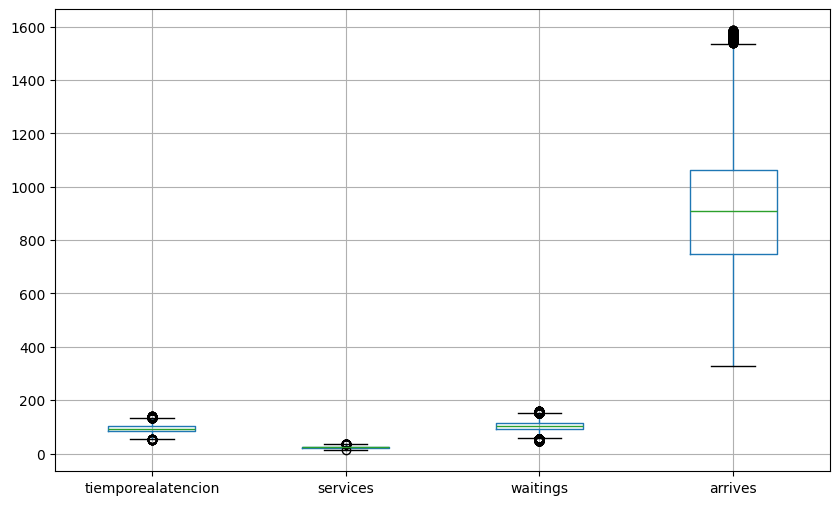

In [148]:
# Boxplots for each variable to show outliers
final_df.boxplot(column=['tiemporealatencion', 'services', 'waitings', 'arrives'], figsize=(10, 6))
plt.show()

In [149]:
final_df.head()

,sucursal,waitings,services,arrives,tiemporealatencion,INT_CheckoutsReal,arrives_scaled,services_scaled,waitings_scaled,tiemporealatencion_scaled
0,4,118.2,30.6,1213.0,106.3470,10.0,0.965713,0.107733,0.038130,0.435641
1,1,83.1,21.0,587.0,82.2148,4.0,-1.140780,-0.085753,-0.118133,-0.734733
3,1,91.8,21.0,587.0,83.7523,4.0,-1.140780,-0.085753,-0.079401,-0.660166
4,51,112.0,23.8,1064.0,92.9797,9.0,0.464328,-0.029319,0.010528,-0.212652
5,51,120.0,24.6,1092.0,109.8120,10.0,0.558548,-0.013196,0.046143,0.603688


### Parte 3: Modelado

In [150]:
from sklearn.model_selection import train_test_split

Separamos en dos data set las variables de entrenamiento y en otro la variable objetivo

In [151]:
df_X = final_df[['waitings', 'services', 'arrives', 'tiemporealatencion']]
df_y = final_df['INT_CheckoutsReal']

In [152]:
#Ajustamos los nombres de nuestras columnas

df_X.rename(columns={
            'waitings': 'tiempoEspera', 
            'services': 'tiempoServicio',
            'arrives': 'tiempoLlegadas'
        }, inplace=True)

C:\Users\SALVA\AppData\Local\Temp\ipykernel_23860\1283902435.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_X.rename(columns={


In [153]:
# Ajustamos el nombre de la columna de la variable objetivo

df_y.rename('numeroCheckouts', inplace=True)

0        10.000000
1         4.000000
3         4.000000
4         9.000000
5        10.000000
           ...    
20026     6.445093
20027     6.445093
20028     6.445093
20029     6.445093
20030     6.445093
Name: numeroCheckouts, Length: 16346, dtype: float64

In [154]:
# df_X.to_csv('df_X.csv', index=False)
# df_y.to_csv('df_y.csv', index=False)

In [155]:
df_X.head()

,tiempoEspera,tiempoServicio,tiempoLlegadas,tiemporealatencion
0,118.2,30.6,1213.0,106.3470
1,83.1,21.0,587.0,82.2148
3,91.8,21.0,587.0,83.7523
4,112.0,23.8,1064.0,92.9797
5,120.0,24.6,1092.0,109.8120


In [156]:
df_y.head()

0    10.0
1     4.0
3     4.0
4     9.0
5    10.0
Name: numeroCheckouts, dtype: float64

Generamos nuestro set de pruebas y entrenamiento

In [157]:
# Separación de pruebas y entrenamiento con un 80% de datos de entrenamiento y 20% de datos de prueba
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=42)

##### Aplicación de PCA (reducción de dimencionalidad)

Para validar el rendimiento de nuestros modelos se aplicará PCA para revisar si obtenemos un mejor rendimiento al momento de reducir la cardinalidad de los datos disponibles y analizaremos ambos resultados

In [158]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [159]:
# Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_X)

In [160]:
# Aplicar PCA para reducir la dimensionalidad a 2 componentes
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

In [161]:
# Crear un DataFrame con los componentes principales
pca_df = pd.DataFrame(data=X_pca, columns=['PCA1', 'PCA2'])
pca_df['int_checkouts'] = df_y.values  # Agregar la variable objetivo al DataFrame

In [162]:
pca_df

,PCA1,PCA2,int_checkouts
0,2.339633,0.003553,10.000000
1,-1.873863,-0.647940,4.000000
2,-1.656759,-0.429575,4.000000
3,0.392627,0.601866,9.000000
4,1.368481,0.304008,10.000000
...,...,...,...
16341,0.788375,-1.295168,6.445093
16342,-0.018883,-1.362960,6.445093
16343,-1.253990,-2.252738,6.445093
16344,1.258923,-0.925376,6.445093


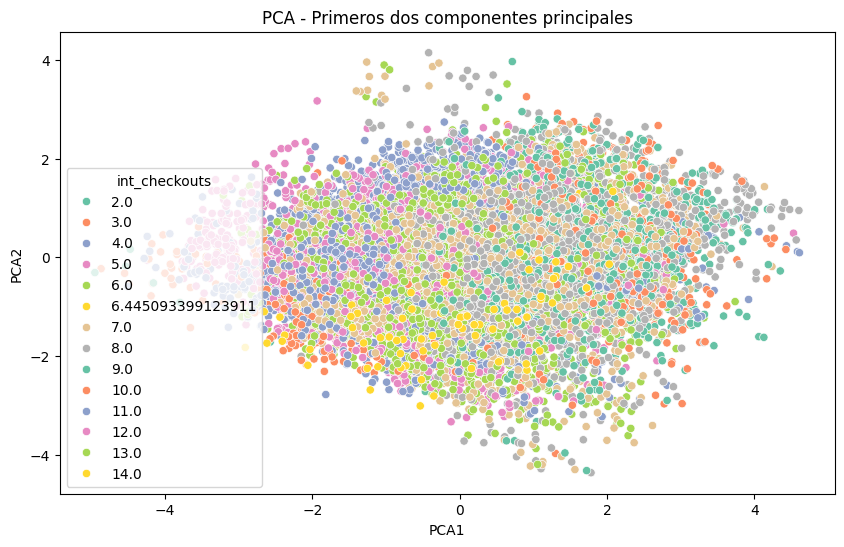

In [163]:
# Graficar los dos primeros componentes principales
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='int_checkouts', data=pca_df, palette='Set2')
plt.title('PCA - Primeros dos componentes principales')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()

In [164]:
# Mostrar la varianza explicada por los componentes principales
print(f"Varianza explicada por el primer componente: {pca.explained_variance_ratio_[0]:.4f}")
print(f"Varianza explicada por el segundo componente: {pca.explained_variance_ratio_[1]:.4f}")

Varianza explicada por el primer componente: 0.5037
Varianza explicada por el segundo componente: 0.2719


In [165]:
# Crear un modelo baseline de regresión (modelo dummy que predice el promedio)
baseline_model = DummyRegressor(strategy="mean")
baseline_model.fit(X_train, y_train)
y_pred_DummyRegressor = baseline_model.predict(X_test)

In [166]:
# Calculate performance metrics for both models
metrics = {
    "Model": ["Dummy Regressor"],
    "Mean Squared Error": [
        mean_squared_error(y_test, y_pred_DummyRegressor)
    ],
    "Mean Absolute Error": [
        mean_absolute_error(y_test, y_pred_DummyRegressor)
    ],
    "R-Squared": [
        r2_score(y_test, y_pred_DummyRegressor)
    ]
}

In [167]:
# Display performance metrics
df_metrics = pd.DataFrame(metrics)
df_metrics

,Model,Mean Squared Error,Mean Absolute Error,R-Squared
0,Dummy Regressor,2.898662,1.406955,-0.000812


En general podemos ver que nos datos tienen un mejor rendimiento sin aplicar necesariamente PCA, por lo que para este caso el modelo se puede explicar de mejor forma con la cardinalidad base de nuestro modelo, esto de cierta forma es lógico debido a que nuestro set de datos no es muy amplio en variables disponibles.

#### Parte 4 Generación de modelos de ML

Para esta sección de la práctica se generarán por lo menos 5 modelos de ML se analizarán los siguientes:
* Regresión lineal
* Regresión polinómica
* Árbol de decisión
* Random Forest
* XGBoost

De los cuales se obtendrá su rendimiento al momento de la ejecución, con la finalidad de poder determinar cuál de estos modelos es el más adecuado para nuestro set de datos propuesto.

In [168]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

results = []

# Función para calcular métricas
def calculate_metrics(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    results.append({
        'Model': model_name,
        'MSE': mse,
        'MAE': mae,
        'R²': r2
    })

1.- Algoritmo de Regresión lineal

Este tipo de algoritmos corresponde a uno de los más simples y ampliamente utilizados. Principalmente busca modelar la relación entre una variable dependiente y una o más variables independientes, ajustando una línea recta a los datos.
Dentro de las características principales tenemos las siguientes:
* Supone la existencia re una relación lineal entre las variables analizadas y la objetivo
* Facilidad en su interpretación y de rápido entrenamiento
* Puede llegar a sufrir de una baja capacidad en su predición si los datos de entrenamiento y prueba no son lineales

In [169]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)
calculate_metrics(y_test, y_pred_linear, 'Linear Regression')

2.- Algoritmo de Regresión polinómica

Este tipo de algorimo toma como referencia la regresión lineal, siendo este una extención que permite capturar las relaciones NO lineales de entre las variables de nuestro data set elevando las varianbles a una potencia superior, con la finalidad de lograr un mejor resultado en variables más complejas.
Las principales caractierísticas de este modelo son las siguientes:
* Premite modelar datos no lineales
* Tiende a un sobreajuste si la dimencionalidad de los variables es muy alta
* Es adecuado cuando la relación esntre variables es compleja

In [170]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2) # Algoritmo de grado 2
X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.transform(X_test)
poly_reg = LinearRegression()
poly_reg.fit(X_poly_train, y_train)
y_pred_poly = poly_reg.predict(X_poly_test)
calculate_metrics(y_test, y_pred_poly, 'Polynomial Regression')

3.- Árbol de decisión

Este modelo crea un árbol donde cada uno de los nodos representa una variable, cada rama representa una regla de decisión y cada hoja representa el resultado. Las características de este modelo son las siguientes:
* Interpretación fácil
* Se adapta bien a los datos no lineales y puede manejrar datos numéricos y categóricos
* Es propenso al sobreajuste

In [171]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
calculate_metrics(y_test, y_pred_dt, 'Decision Tree')

4.- Random forest

Es un algoritmo basado en la conjunción de un bosque de árboles de decisión que lo hace más sobusto al momento de generar las predicciones. Sus características son las siguientes:
* Reduce el sobreajuste que puede ocurrir en el único árbol de decisión
* Generaliza bien en una variedad de problemas

In [172]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
calculate_metrics(y_test, y_pred_rf, 'Random Forest')

5.- XGBoost

Es una técnica de boosting basada en árboles de decisión. Mejora de manera iterativa los modelos basados en los errores de los modelos anteriores. Se ha convertido en un estándar para muchos problemas de machine learning debido a su rendimiento y velocidad.
* Alto rendimiento y eficiencia, especialmente en datasets grandes.
* Es capaz de manejar interacciones complejas entre las variables.
* Puede ser más difícil de interpretar que otros modelos como la regresión o los árboles de decisión.

In [173]:
from xgboost import XGBRegressor

xgb = XGBRegressor(objective='reg:squarederror', random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
calculate_metrics(y_test, y_pred_xgb, 'XGBoost')

6.- SVR

El modelo SVR extiende el concepto de las máquinas de soporte vectorial (SVM) para tareas de regresión. Intenta encontrar un hiperplano que tenga el margen máximo en un espacio de alta dimensionalidad, permitiendo cierto error dentro de un límite de tolerancia.
* Puede modelar relaciones complejas, no lineales, usando diferentes kernels (por ejemplo, el kernel radial).
* Es robusto a los outliers debido al uso de márgenes.
* El costo computacional puede ser alto, especialmente para datasets grandes.

In [174]:
from sklearn.svm import SVR

svr = SVR(kernel='rbf')  # Usamos el kernel RBF para la no linealidad
svr.fit(X_train, y_train.values.ravel())  # Aplanamos y_train a una matriz 1D
y_pred_svr = svr.predict(X_test)
calculate_metrics(y_test, y_pred_svr, 'SVR')

A continuación se viusaliza un cuadro comparativo del rendimiento de cada uno de los algoritmos analizados y el rendimiento obtenido bajo las méticas:
* MSE
* MAE
* R^2

In [175]:
results_df = pd.DataFrame(results)
results_df

,Model,MSE,MAE,R²
0,Linear Regression,1.203853,0.881705,0.584349
1,Polynomial Regression,1.120000,0.845465,0.613301
2,Decision Tree,1.553387,0.819164,0.463667
3,Random Forest,0.830014,0.667492,0.713424
4,XGBoost,0.915334,0.719383,0.683965
5,SVR,1.277302,0.899846,0.558990


C:\Users\SALVA\AppData\Local\Temp\ipykernel_23860\3293481278.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(results_df['Model'], rotation=90)
C:\Users\SALVA\AppData\Local\Temp\ipykernel_23860\3293481278.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(results_df['Model'], rotation=90)
C:\Users\SALVA\AppData\Local\Temp\ipykernel_23860\3293481278.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(results_df['Model'], rotation=90)


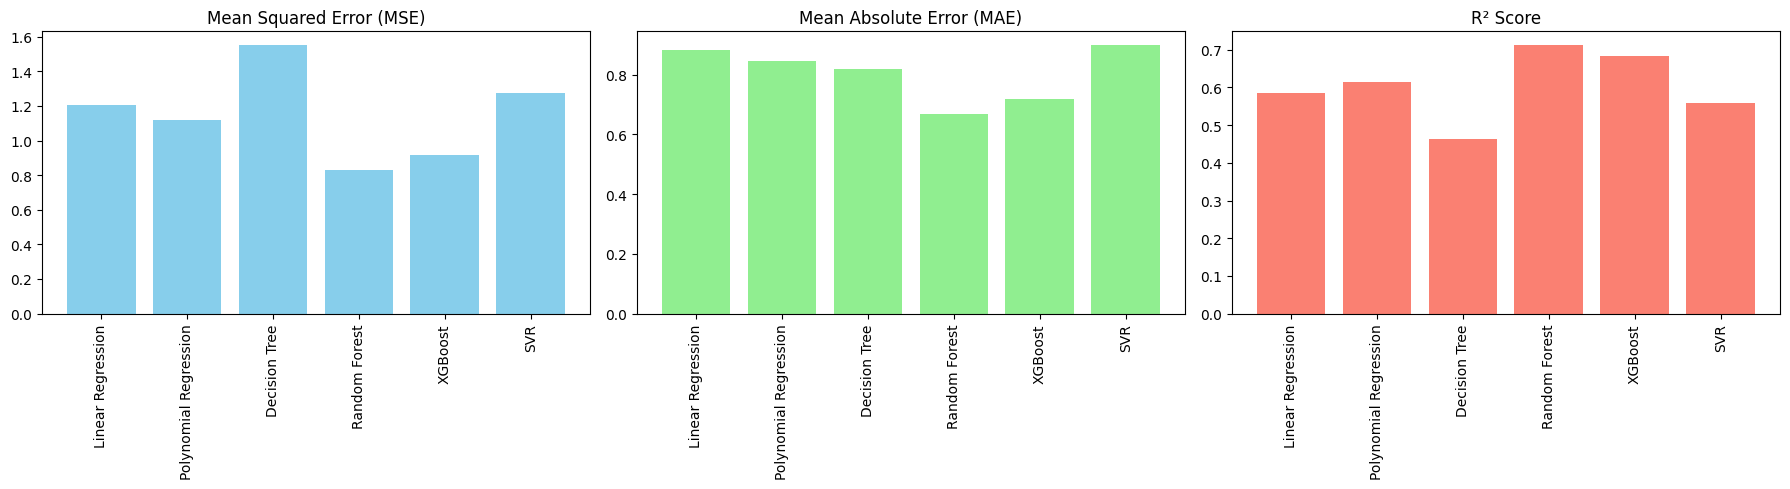

In [176]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Gráfica de MSE
axes[0].bar(results_df['Model'], results_df['MSE'], color='skyblue')
axes[0].set_title('Mean Squared Error (MSE)')
axes[0].set_xticklabels(results_df['Model'], rotation=90)

# Gráfica de MAE
axes[1].bar(results_df['Model'], results_df['MAE'], color='lightgreen')
axes[1].set_title('Mean Absolute Error (MAE)')
axes[1].set_xticklabels(results_df['Model'], rotation=90)

# Gráfica de R²
axes[2].bar(results_df['Model'], results_df['R²'], color='salmon')
axes[2].set_title('R² Score')
axes[2].set_xticklabels(results_df['Model'], rotation=90)

plt.tight_layout()
plt.show()

#### Ajuste de hiperparámetros de los modelos seleccionados

In [180]:
# !pip install xgboost

In [181]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [182]:
# Definir hiperparámetros para ajustar en Random Forest
rf_param_grid = {
    'n_estimators': [50, 100, 200],          # Número de árboles en el bosque
    'max_depth': [None, 10, 20, 30],         # Profundidad máxima de los árboles
    'min_samples_split': [2, 5, 10],         # Número mínimo de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4],           # Número mínimo de muestras para ser una hoja
    'bootstrap': [True, False]               # Si utilizar bootstrap en el muestreo
}

In [183]:
# Definir hiperparámetros para ajustar en XGBoost
xgb_param_grid = {
    'n_estimators': [50, 100, 200],          # Número de árboles
    'learning_rate': [0.01, 0.1, 0.2],       # Tasa de aprendizaje
    'max_depth': [3, 5, 10, 15],             # Profundidad máxima de los árboles
    'colsample_bytree': [0.3, 0.7],          # Proporción de características seleccionadas por árbol
    'subsample': [0.7, 1.0],                 # Fracción de muestras para entrenar cada árbol
    'reg_alpha': [0, 0.1, 1],                # Regularización L1
    'reg_lambda': [1, 1.5, 2]                # Regularización L2
}

In [184]:
# Ajuste de hiperparámetros usando RandomizedSearchCV para Random Forest
rf_random = RandomizedSearchCV(estimator=RandomForestRegressor(), param_distributions=rf_param_grid, 
                               n_iter=10, cv=3, verbose=2, random_state=42, n_jobs=-1)
rf_random.fit(X_train, y_train.values.ravel())  # Ajuste del modelo

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200]},
                   random_state=42, verbose=2)

In [185]:
# Ajuste de hiperparámetros usando RandomizedSearchCV para XGBoost
xgb_random = RandomizedSearchCV(estimator=XGBRegressor(objective='reg:squarederror'), param_distributions=xgb_param_grid, 
                                n_iter=10, cv=3, verbose=2, random_state=42, n_jobs=-1)
xgb_random.fit(X_train, y_train.values.ravel())  # Ajuste del modelo

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, ...),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.3, 0.7],
                                        'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 5, 10, 15],
                                        'n_estimators': [50, 100, 200],
                                        'reg_alpha': [0, 0.1, 1],
                                        'reg_lambda': [1, 1.5, 2],
                                        'subsample': [0.7, 1.0]},
                   random_state=42, verbose=2)

In [186]:
# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros para Random Forest:")
print(rf_random.best_params_)

Mejores hiperparámetros para Random Forest:
{'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 20, 'bootstrap': True}


In [187]:
print("Mejores hiperparámetros para XGBoost:")
print(xgb_random.best_params_)

Mejores hiperparámetros para XGBoost:
{'subsample': 0.7, 'reg_lambda': 2, 'reg_alpha': 0.1, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.2, 'colsample_bytree': 0.7}


In [188]:
# Entrenar Random Forest con los mejores hiperparámetros
best_rf = rf_random.best_estimator_
y_pred_rf_best = best_rf.predict(X_test)

In [189]:
# Entrenar XGBoost con los mejores hiperparámetros
best_xgb = xgb_random.best_estimator_
y_pred_xgb_best = best_xgb.predict(X_test)

In [190]:
# Evaluar los modelos ajustados
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Para Random Forest ajustado
print("Random Forest Ajustado:")
print(f"MSE: {mean_squared_error(y_test, y_pred_rf_best)}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_rf_best)}")
print(f"R²: {r2_score(y_test, y_pred_rf_best)}")

# Para XGBoost ajustado
print("XGBoost Ajustado:")
print(f"MSE: {mean_squared_error(y_test, y_pred_xgb_best)}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_xgb_best)}")
print(f"R²: {r2_score(y_test, y_pred_xgb_best)}")

Random Forest Ajustado:
MSE: 0.845136636213945
MAE: 0.6833554647068565
R²: 0.7082022873356226
XGBoost Ajustado:
MSE: 0.9796685409656224
MAE: 0.7630073359982319
R²: 0.6617528726436015


In [178]:
data = {
    'Modelo': ['Random Forest', 'XGBoost'],
    'Características principales': [
        'Ensamble de múltiples árboles con bagging',
        'Boosting basado en el gradiente con regularización'
    ],
    'Ventajas': [
        'Menos propenso a sobreajuste, fácil de implementar',
        'Altamente eficiente, rendimiento superior en predicción'
    ],
    'Desventajas': [
        'Menos interpretable, más lento en inferencia',
        'Más complejo de ajustar, requiere más tuning'
    ]
}

comparison_df = pd.DataFrame(data)

## Justificación de modelo seleccionado

Como parte de nuestra propuesta, hemos seleccionado como primera opción el algoritmo de aprendizaje supervisado Random Forest para realizar el análisis de la información. En las próximas semanas, se llevará a cabo un análisis detallado del modelo y su rendimiento.

**Random Forest** es un algoritmo de aprendizaje supervisado utilizado tanto para clasificación como para regresión. Su uso está justificado por los siguientes puntos:

*   **Manejo de Datos No Lineales**: Las relaciones entre las variables a menudo no son lineales. Random Forest puede capturar estas relaciones complejas sin necesidad de transformar los datos.
*   **Reducción del Overfitting**: Al utilizar múltiples árboles de decisión y promediar sus resultados, Random Forest reduce el riesgo de sobreajuste, lo que mejora la capacidad de generalización del modelo.
*   **Importancia de Variables**: Random Forest proporciona métricas sobre la importancia de cada variable en las predicciones, lo que permite identificar mejor los factores más influyentes en el número de cajas necesarias.


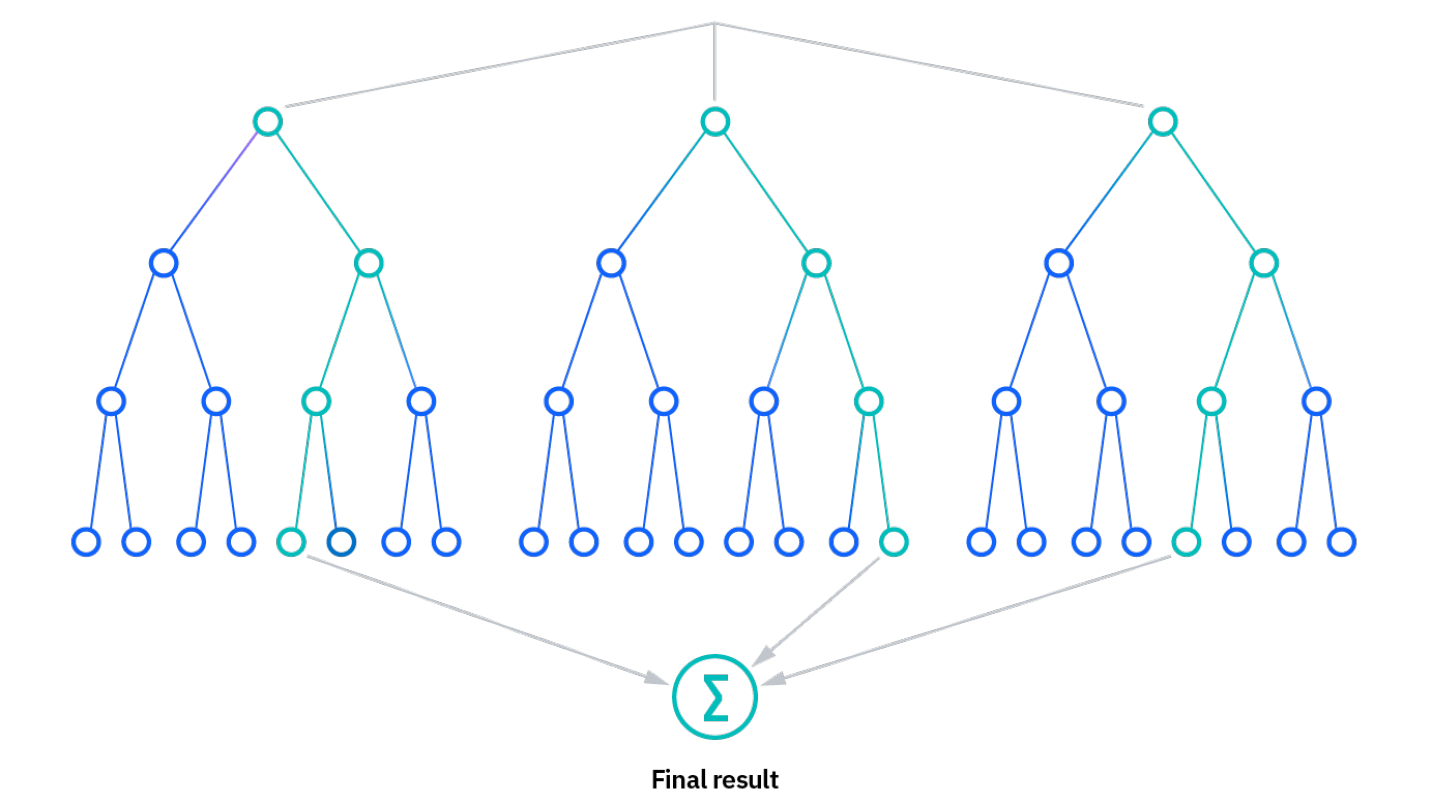

Conclusión:
* Random Forest es una excelente opción si se busca un modelo robusto, fácil de implementar y que pueda manejar datos complejos con relaciones no lineales sin mucho riesgo de sobreajuste.
* XGBoost es ideal si se tiene un dataset grande. Es más eficiente en términos de precisión, pero puede requerir más ajuste de hiperparámetros.
Ambos modelos son muy potentes, y la elección entre ellos dependerá de tus prioridades: si prefieres facilidad de uso y menor riesgo de sobreajuste, elige Random Forest; si necesitas máxima precisión y tienes tiempo para ajustar parámetros, XGBoost es una excelente opción.

In [179]:
comparison_df

,Modelo,Características principales,Ventajas,Desventajas
0,Random Forest,Ensamble de múltiples árboles con bagging,"Menos propenso a sobreajuste, fácil de impleme...","Menos interpretable, más lento en inferencia"
1,XGBoost,Boosting basado en el gradiente con regulariza...,"Altamente eficiente, rendimiento superior en p...","Más complejo de ajustar, requiere más tuning"


#### Referencias

* Ibm. (2023, 3 mayo). Random Forest. ¿Qué es un bosque aleatorio? https://www.ibm.com/mx-es/topics/random-forest
* Drucker, H., Burges, C. J. C., Kaufman, L., Smola, A., & Vapnik, V. (1997). Support Vector Regression Machines. Advances in Neural Information Processing Systems.
* Hastie, T., Tibshirani, R., & Friedman, J. (2009). The Elements of Statistical Learning. Springer Science & Business Media.
* James, G., Witten, D., Hastie, T., & Tibshirani, R. (2013). An Introduction to Statistical Learning with Applications in R. Springer.
* Quinlan, J. R. (1986). Induction of Decision Trees. Machine Learning, 1(1), 81–106.
* Breiman, L. (2001). Random Forests. Machine Learning, 45(1), 5–32.